# Starbucks Capstone Challenge Notebook



## Background : 

The businesses want to target right customers throughout the customer journey which helps to reduce the marketing budget, customer satisfaction as well increase the profits.  Machine learning (ML) and artificial intelligence (AI) technologies are helping automate the digital marketing with real time decision making such as selecting best messaging platform, best timing, and the best offering to the individual customer by integrating data from different platforms [1-4].

Udacity's Starbucks Capstone challenge project  data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Machine learning technique will be used in order to develop effective marketing strategy for the Starbucks business using the available data.  


# Problem Statement 

Starbucks sends out an offer to users of the mobile app every few days. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). The given dataset contains demographic data a record of transaction and details about offer information. Before developing a predictive model, exploratory data analysis and customer segmentation will be carried out which will help Starbucks business in better targeted marketing.  

It is important to know your customers in order to increase business. First, customer segmentation using unsupervised machine learning technique K-means clustering will be carried out to understand current customer characteristics and demographics. Second  the best performing supervised machine learning model will be build by comparing random forest and boosting ensemble models performance based on the metrics to predict if customer will respond to an offer or not for better targeted marketing. 


# 
Following are the project design steps carried out to execute this project


1. Data Cleaning and Exploratory data analysis (EDA)


2. Feature engineering - create new features from the 
 

3. Customer segmentation to know Starbucks current customers

4.  Offer prediction model - the best performing supervised machine learning model will be build by comparing random forest and boosting ensemble models based on the metrics to predict if customer will respond to an offer or not for better targeted marketing. 
    
# Challanges 

- Not all users receive the same offer
- Different validity period for the offer type and informational offer to influence customer.
- Customer might make a purchase through the app without having received an offer or seen an offer
- A user can receive an offer, never actually view the offer, and still complete the offer


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import matplotlib
#% matplotlib inline|



# Part 1 :  Initial Dataset Statistics and basic EDA



In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)

# Check size of the data set, basic statistics and null value counts
print('portfolio shape {}:' .format(portfolio.shape)) 
print('portfolio statistics:' ) 
print((portfolio.describe()))
print('portfolio null count:') 
print((portfolio.isnull().sum()))
 

portfolio shape (10, 6):
portfolio statistics:
       difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000
portfolio null count:
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


In [3]:
print('portfolio data charecteristics  {}:' .format(portfolio.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes
portfolio data charecteristics  None:


In [4]:
# cleaning function portfolio
# credit -  https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
# credit - https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
# credit -https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list/45312577#45312577

def portfolio_clean(portfolio):

    """ 
    Clean, select and transform a DataFrame containing information about offer type and duration
    INPUT:
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
    OUTPUT:
        portfolio: clean transformed portfolio DataFrame
    """  
    
   # portfolio = portfolio.assign(**pd.get_dummies(portfolio.channels.apply(lambda x:pd.Series(x)).stack()
                                                    #.reset_index(level=1,drop=True)).sum(level=0))
    #portfolio = portfolio.assign(**pd.get_dummies(portfolio.offer_type.apply(lambda x:pd.Series(x)).stack()
                                                   # .reset_index(level=1,drop=True)).sum(level=0))
    #portfolio['id'] = [offer_id_col[item] for item in portfolio_df['id']] 
    portfolio.rename(columns={'id':'offer_id', 'reward': 'reward_offered'}, inplace =True)
    
    #offer_type_col = {'bogo':'1', 'informational':'2','discount':'3'}
    #portfolio['offer_type'] = [offer_type_col[item] for item in portfolio['offer_type']] 
    
    portfolio.drop(['channels'], axis=1, inplace=True)
    
    return portfolio



In [5]:
portfolio_df=portfolio_clean(portfolio)

In [6]:
portfolio_df.head()

,difficulty,duration,offer_id,offer_type,reward_offered
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


### summary of  portfolio statistics
- encode offer_type columns
- no direct reward for the information type offer so we will need a strategy to check its offer effetiveness
- duration will be helpful to seperate offer and transaction dataframes for further analysis. 

In [7]:
# read in the json files
profile = pd.read_json('profile.json', orient='records', lines=True)

# Check size of the data set, basic statistics and null value counts
print('profile  shape is {}:' .format(profile.shape)) 
print('profile statistics  {}:' .format(profile.describe())) 
print('profile data charecteristics   {}:' .format(profile.info())) 
print('profile null count{}:' .format(profile.isnull().sum()))

profile  shape is (17000, 5):
profile statistics                  age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
profile data charecteristics   None:
profile null countage                    0
became_memb

In [ ]:
profile.age >

In [8]:
# cleaning function profile
# credit -  https://stackoverflow.com/questions/43133605/convert-integer-yyyymmdd-to-date-format-mm-dd-yyyy-in-python
import datetime

def profile_clean(profile):

    """ 
    Clean, select and transform a DataFrame containing a demographic data for each customer
    INPUT:
        profile: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
    OUTPUT:
        profile: clean and transformed profile DataFrame
    """  
    #profile['date_time']  = profile[['became_member_on']].applymap(str).applymap(lambda s: "{}/{}/{}"
                                                                                # .format( s[0:4],s[4:6],s[6:]))
        # We can calculate membershipt years using became member on data to see how long customer is starbucks member
    profile['date_time'] =pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
    end_time =(datetime.datetime.today().date())
    start_time =(profile['date_time'].dt.date)
    
    profile['membership_years']=  (end_time -start_time)
    profile['membership_years'] = round((pd.to_numeric(profile['membership_years'].dt.days, downcast='integer')/365),)
   
                            
    # only gender and income column showed nan values. We will clean the data # dropped data comment
    profile= profile.dropna(axis=0, subset=['gender'])
    
    # keep only year unless want to calculate membership period then we may need month and date 
    profile['year'] = pd.DatetimeIndex(profile['date_time']).year   

    profile.rename(columns={'id':'customer_id'}, inplace =True)
    profile.drop(['date_time', 'became_member_on'], axis=1,inplace=True)

    return profile


In [9]:
profile_df=profile_clean(profile)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
profile_df.head()

,age,gender,customer_id,income,membership_years,year
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,3.0,2017
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,3.0,2017
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2.0,2018
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2.0,2018
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2.0,2017


####  Summary of profile dataframe
- age, gender catgorical features encoded later
- become_member_on  changed to membership years.
- age maximum value : 118 - looks like outlier
- income and gender columns have more missing values - 2175 which are corresponding to age outlier. We will check overall missing values in the combined dataset to decided if we need to impute or delete missing values.

In [11]:
# read in the json files
transcript = pd.read_json('transcript.json', orient='records', lines=True)

# Check size of the data set, basic statistics and null value counts
print('transcript  shape is {}: ' .format(transcript.shape)) 
print('transcript statistics:' )
print(transcript.describe()) 
print('transcript data charecteristics:')
print(transcript.info())
print('transcript null count:' )
print(transcript.isnull().sum())

transcript  shape is (306534, 4): 
transcript statistics:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000
transcript data charecteristics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
transcript null count:
event     0
person    0
time      0
value     0
dtype: int64


In [12]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [13]:
# transcript value contains amount related to transaction, offer id and reward given 
transcript.tail(5)

,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [14]:
# cleaning function transcript
# credit - https://stackoverflow.com/questions/58383927/convert-series-of-dict-and-concat-to-dataframe
#https://stackoverflow.com/questions/38134012/pandas-dataframe-fillna-only-some-columns-in-place

def transcript_clean(transcript):

    """ 
    Clean, select and transform a DataFrame containing the records for transactions,
    offer types : received, viewed, completed
    INPUT:
        transcript: DataFrame containing records of transaction, customer id, time and value
                   each offer (duration, type, etc.)
    OUTPUT:
        transcript: clean and transformed transcript DataFrame
    """  
    # value column contains disctionary with amount, reward and offer id 
    # it results in nan columns which we will clean later
    transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis = 1)
   # transcript = transcript.assign(**pd.get_dummies(transcript.event.apply(lambda x:pd.Series(x)).stack()
                                                   # .reset_index(level=1,drop=True)).sum(level=0))
    
    # we will delete offer_id column , it contains duplicate/missing information from offer id related to reward - 
    #we can fill that information from offer_id column - reward offer id
    transcript['offer_id'].fillna(transcript['offer id'],inplace=True)
    transcript.rename(columns={'person':'customer_id', 'reward':'reward_given'}, inplace =True)
    
    #convert number of days - time column to 
    transcript['time'] = round(transcript['time']/24).astype(int)
    #transcript= pd.concat([transcript, pd.get_dummies(transcript['event'])], axis= 1)
    transcript.drop(['value', 'offer id'], axis=1,inplace=True)

    return transcript

In [15]:
transcript_df=transcript_clean(transcript)

In [16]:
transcript_df.head()

,event,customer_id,time,amount,offer_id,reward_given
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [17]:
profile.head()

,age,became_member_on,gender,id,income,date_time,membership_years
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,3.0
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,3.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,2.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,3.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,3.0


###  Missing Data analysis - 
Rule of thumb, if there is less than 5% of missing data and features are not important then we can delete. However, We have almost 12.79% missing customers profile. It belongs to gender and income  columns. To further understand mising data : We will have a closer look at the transcript and profile combined dataframe. We can check that how it can affect overall segmentation analysis and offer predictions modeling. 

In [18]:
print('Missing data percentage in the profile dataset ')
print(profile.isna().sum()*100/(profile.id.count()))

Missing data percentage in the profile dataset 
age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
date_time            0.000000
membership_years     0.000000
dtype: float64


In [19]:
profile.rename(columns={'id':'customer_id'}, inplace =True)
#profile.drop(['reward_given', 'date_time id'], axis=1,inplace=True)
df_merged=pd.merge(transcript_df,  profile_df, on='customer_id', how='left')

In [20]:
df_merged.head()

,event,customer_id,time,amount,offer_id,reward_given,age,gender,income,membership_years,year
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,3.0,2017.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,2.0,2018.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
print('Missing offer completed data  due to gender and age data')
print(df_merged[(df_merged['gender'].isna())&(df_merged['event']=='offer completed')
               ].customer_id.count()*100/df_merged[(df_merged['event']=='offer completed')].customer_id.count())   # add index

Missing offer completed data  due to gender and age data
3.3800887459424045


In [22]:
df_merged.event.count()

306534

We will delete these values, since offer related missing trasaction ARE less than 5%. 



#### Transcript data analysis

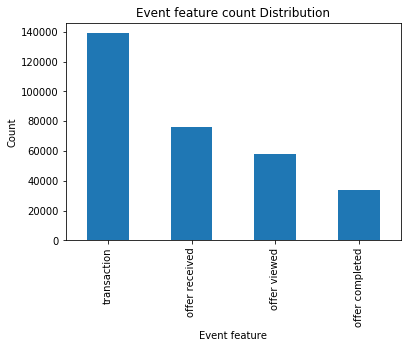

In [23]:

#Let's check different offer and transactions event counts
transcript_df['event'].value_counts().plot.bar()
transcript_df.groupby(['event']).customer_id.count()
plt.xlabel('Event feature')
plt.ylabel('Count')
plt.title('Event feature count Distribution')
plt.show()

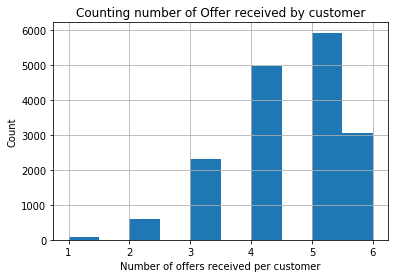

offer completed transactions are  24.165725101293244  % from all transactions
and many customers recieved more than 4 offers.


In [24]:
#### Let's see hpw many offers recieved per customers

transcript_df[transcript_df['event']=='offer received'].groupby('customer_id')['event'].count().hist()
plt.xlabel('Number of offers received per customer')
plt.ylabel('Count')
plt.title('Counting number of Offer received by customer')
plt.show()

# we have not seperated informational offer transactions. 
print('offer completed transactions are ',(df_merged[(df_merged['event']=='offer completed')].customer_id.count()*100/
                                           df_merged[(df_merged['event']=='transaction')].event.count()),' % from all transactions' )
print('and many customers recieved more than 4 offers.')

In [25]:
#Lets see how many offeres were sent from different offer types (bogo, discount and informational.

df_offer_type =df_merged.offer_id.value_counts().to_frame().reset_index()
offer_id_col = {'ae264e3637204a6fb9bb56bc8210ddfd':'bogo1',
       '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo2',
       '3f207df678b143eea3cee63160fa8bed':'informational1',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo3',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7':'discount1',
       '2298d6c36e964ae4a3e7e9706d1fb8c2':'discount2',
       'fafdcd668e3743c1bb461111dcafc2a4':'discount3',
       '5a8bc65990b245e5a138643cd4eb9837':'informational2',
       'f19421c1d4aa40978ebb69ca19b0e20d':'bogo4',
       '2906b810c7d4411798c6938adc9daaa5':'discount4'}

df_offer_type['index'] = [offer_id_col[item] for item in df_offer_type['index']] 
df_offer_type.rename(columns={'offer_id':'count'}, inplace=True)
df_offer_type

,index,count
0,discount3,20241
1,discount2,20139
2,bogo4,19131
3,bogo2,18222
4,bogo1,18062
5,bogo3,16202
6,discount4,15767
7,informational2,14305
8,discount1,13751
9,informational1,11761


More offered were sent of type discount 3, discount 2, bogo4, bogo2. 
We will check later which offer type was effective. 

In [26]:
# lets answer some questions to understand transcript dataframe

print('How many transaction are related to offer sent to the customer')
print(len(transcript_df[(transcript_df['offer_id'].notnull()) & (transcript_df['reward_given'].notnull())]))

print('How many customers did not respond to the sent offer')
print(transcript_df[(transcript_df['offer_id'].notnull()) & (transcript_df['reward_given'].isnull())].count())

# This may contain some informational offer related transaction
print('How many customers transactions are not respond to the sent offer')
print((transcript_df[(transcript_df['amount'].notnull())]).count())

# transaction at time=0 means . 
print('How many transaction happened without receiving offer at time=0')
print(transcript_df[(transcript_df['time']==0)&(transcript_df['amount'])].event.count())





How many transaction are related to offer sent to the customer
33579
How many customers did not respond to the sent offer
event           134002
customer_id     134002
time            134002
amount               0
offer_id        134002
reward_given         0
dtype: int64
How many customers transactions are not respond to the sent offer
event           138953
customer_id     138953
time            138953
amount          138953
offer_id             0
reward_given         0
dtype: int64
How many transaction happened without receiving offer at time=0
2280


#### Portfolio data analysis combining transcript

In [27]:
# let's merge portfolio dataset
df_temp = df_merged.merge(portfolio_df,how='left',on='offer_id')

In [28]:
df_temp.head()

,event,customer_id,time,amount,offer_id,reward_given,age,gender,income,membership_years,year,difficulty,duration,offer_type,reward_offered
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,3.0,2017.0,5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,NaN,NaN,20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,2.0,2018.0,10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,5.0,bogo,10.0


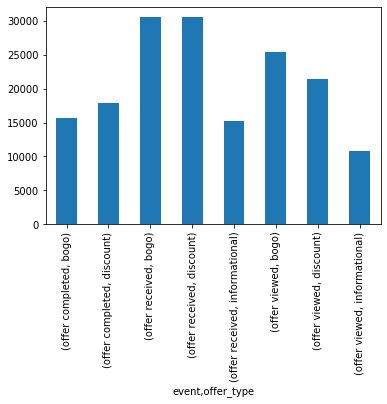

In [29]:
# Let's check offer type count by event
df_temp.groupby(['event','offer_type'])['customer_id'].count().plot.bar()



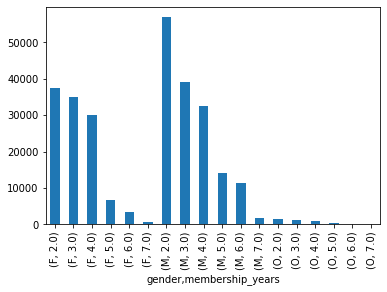

In [142]:
# plot age, gender and membership years and year 
df_temp.groupby(['gender','membership_years'])['customer_id'].count().plot.bar()

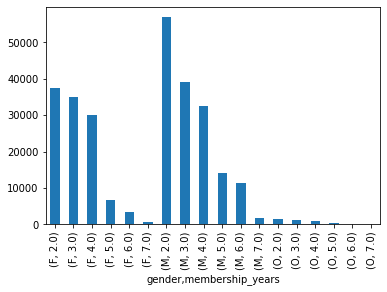

In [146]:
df_temp.groupby(['gender','membership_years'])['customer_id'].count().plot.bar()

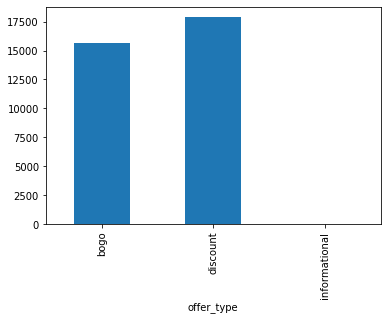

In [143]:
# Let's check how many rewards are given overall 
df_temp.groupby('offer_type')['reward_given'].count().plot.bar()

#### profile data analysis

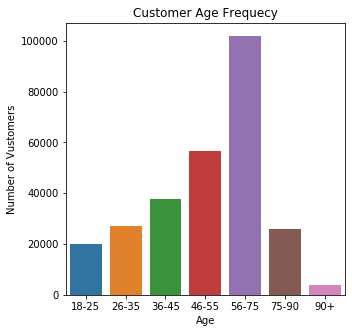

In [154]:
import seaborn as sns
#https://github.com/cdabakoglu/data-science/blob/master/Mall_Customers_KMeans/Mall_Customers_KMeans.ipynb
age18_25 = df_merged.age[(df_merged.age <= 25) & (df_merged.age >= 18)]
age26_35 = df_merged.age[(df_merged.age <= 35) & (df_merged.age >= 26)]
age36_45 = df_merged.age[(df_merged.age <= 45) & (df_merged.age >= 36)]
age46_55 = df_merged.age[(df_merged.age <= 55) & (df_merged.age >= 46)]
age56_75 = df_merged.age[(df_merged.age <= 75) & (df_merged.age >= 56)]
age76_90 = df_merged.age[(df_merged.age <= 90) & (df_merged.age >= 76)]
age90above = df_merged.age[df_merged.age >= 91]
age_range= ['18-25','26-35','36-45','46-55','56-75','75-90','90+']
count = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),
         len(age56_75.values),len(age76_90.values),len(age90above.values)]

plt.figure(figsize=(5,5))
sns.barplot(x=age_range, y=count)
plt.title("Customer Age Frequecy")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.show()

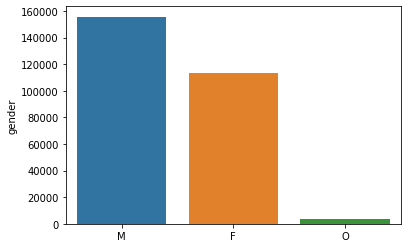

In [178]:
#https://stackoverflow.com/questions/31460146/plotting-value-counts-in-seaborn-barplot

sns.barplot(x=df_temp.gender.value_counts().index, y=df_temp.gender.value_counts())

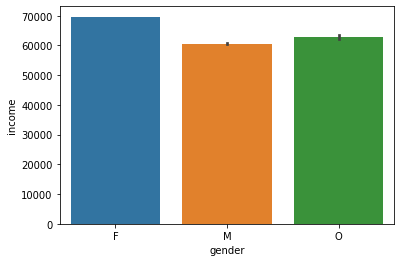

In [183]:
sns.barplot(x=df_temp.gender, y=df_temp.income)

In [ ]:


gender_offer_completed = user_demographic.groupby('gender', as_index = False).agg({'perc_offer_completed': 'mean'})
plt.bar(gender_offer_completed.gender.tolist(), gender_offer_completed.perc_offer_completed.tolist())
plt.title('Percentage of Offer Completed by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage of Offer Completed')
plt.show();



In [ ]:
We can see that salary range 

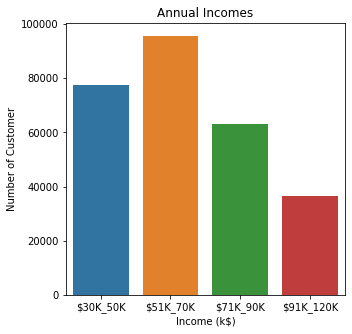

In [44]:
in30K_50K = df_merged['income'][(df_merged['income'] >= 30000) & (df_merged['income'] <= 50000)]
in51K_70K = df_merged['income'][(df_merged['income'] >= 50001) & (df_merged['income'] <= 70000)]
in71K_90K = df_merged['income'][(df_merged['income'] >= 70001) & (df_merged['income'] <= 90000)]
in91K_120K = df_merged['income'][(df_merged['income'] >= 90001) & (df_merged['income'] <= 120000)]


income_range = [ "$30K_50K", "$51K_70K", "$71K_90K", "$91K_120K"]
frequency = [len(in30K_50K.values), len(in51K_70K.values), len(in71K_90K.values), len(in91K_120K.values)]

plt.figure(figsize=(5,5))
sns.barplot(x=income_range, y=frequency)
plt.title("Annual Incomes")
plt.xlabel("Income (k$)")
plt.ylabel("Number of Customer")
plt.show()

Overall startbucks promotional offer effectiveness 

## Part II
  scaling, and feature engineering. 


offer_completion_rate = Number of completed offers trasaction / Number of offers sent (all offers sum)
# Lets check how many offer related transaction
54% of data will be used to charecterize demographic#http://fluidsurveys.com/university/difference-response-rate-completion-rate/
# offer completion rate 
#df_temp2['offer_completion_rate'] =

In [45]:
df_temp.head()

,event,customer_id,time,amount,offer_id,reward_given,age,gender,income,membership_years,year,difficulty,duration,offer_type,reward_offered
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,3.0,2017.0,5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,NaN,NaN,20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,2.0,2018.0,10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,5.0,bogo,10.0


In [46]:
# count bogo, discount and informational  offer received by customer
offer_received = df_temp[df_temp['event']=='offer received'].groupby('customer_id').offer_type.value_counts().unstack()
offer_received.reset_index(drop=False,inplace=True)
offer_received=offer_received.fillna(0)
offer_received.rename_axis(None, axis=1,inplace =True)
offer_received['total_offer_recieved'] = offer_received['bogo'] + offer_received['discount']+offer_received['informational']
offer_received['total_off_recev_bo_dis'] = offer_received['bogo'] + offer_received['discount']


offer_received.rename(columns={'bogo':'offer_recieved_bogo', 'discount':'offer_recieved_discount',
                                    'informational': 'offer_recieved_informational'},inplace =True)

In [47]:
#count offer completed by each customer
offer_completed =df_temp[df_temp['event']=='offer completed'].groupby('customer_id').offer_type.value_counts().unstack()
offer_completed.reset_index(drop=False,inplace=True)
offer_completed=offer_completed.fillna(0)
offer_completed.rename_axis(None, axis=1,inplace =True)
offer_completed['total_offer_completed'] = offer_completed['bogo'] + offer_completed['discount']
offer_completed.rename(columns={'bogo':'offer_completed_bogo', 'discount':'offer_completed_discount'}, inplace =True)
offer_completed['reward_offered'] = df_temp['reward_given'] - df_temp['difficulty']

In [48]:
#count ho many offers viewed by each customer
offer_viewed =df_temp[df_temp['event']=='offer viewed'].groupby('customer_id').offer_type.value_counts().unstack()
offer_viewed.reset_index(drop=False,inplace=True)
offer_viewed=offer_viewed.fillna(0)
offer_viewed['total_offer_viewed'] = offer_viewed['bogo'] + offer_viewed['discount']+offer_viewed['informational']
offer_viewed['total_off_viewed_bo+dis'] = offer_viewed['bogo'] + offer_viewed['discount']
offer_viewed['total_off_viewed_informational'] = offer_viewed['total_offer_viewed']-offer_viewed['total_off_viewed_bo+dis'] 
offer_viewed.rename(columns={'bogo':'offer_viewed_bogo', 'discount':'offer_viewed_discount',
                                    'informational': 'offer_viewed_informational'},inplace =True)

In [49]:
# calculate total transaction amount for each customer.
total_transaction_amount=df_temp.groupby('customer_id').amount.sum().to_frame().reset_index()
total_transaction_amount.rename(columns={'amount':'total_transaction_amount'},inplace=True)
# calculate total transaction count for each customer
total_transaction_count=df_temp[df_temp['event']=='transaction'].groupby('customer_id').event.count().to_frame().reset_index()
total_transaction_count.rename(columns={'event':'total_transaction_count'},inplace=True)
#calculate total reward given to each customer
total_reward_given = df_temp.groupby('customer_id').reward_given.sum().to_frame().reset_index()
total_reward_given.rename(columns={'reward_given':'total_reward_given'},inplace=True)
# calculate total offer related transaction count 
#temp4=df_temp[(transcript_dummy['transaction']==1)&((transcript_dummy['offer completed']==1))].groupby('customer_id').event.count().to_frame().reset_index()
#temp4.rename(columns={'event':'total_transaction_count'},inplace=True)

In [50]:
from functools import reduce
demographic_df=reduce(lambda x,y: pd.merge(x,y, on='customer_id', how='outer'),
                      [offer_received,offer_viewed,offer_completed,total_transaction_amount,
                       total_transaction_count,total_reward_given])

In [51]:
demographic_df.head()


,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,total_off_viewed_informational,offer_completed_bogo,offer_completed_discount,total_offer_completed,total_transaction_amount,total_transaction_count,total_reward_given
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,2.0,2.0,1.0,2.0,3.0,127.60,8.0,9.0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,NaN,4.09,3.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,2.0,1.0,2.0,3.0,79.46,5.0,13.0
3,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,3.0,196.86,8.0,14.0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,3.0,1.0,2.0,1.0,3.0,154.05,12.0,13.0


In [52]:
# transaction only customers - i.e. transaction occured without offer
demographic_df['transaction_onlycustomers'] = np.where(demographic_df['total_offer_completed'].isnull(), 1, 0)
# offer view rate - all type of offer sent and viewed to check how much effective 
demographic_df['offer_view_rate']= demographic_df['total_offer_viewed']/demographic_df['total_offer_recieved']
# how
demographic_df['offer_completion_rate']=demographic_df['total_offer_completed']/demographic_df['total_off_recev_bo_dis']
#
demographic_df['bogo_completion_rate']=demographic_df['offer_completed_bogo']/demographic_df['offer_recieved_bogo']
#
demographic_df['discount_completion_rate']=demographic_df['offer_completed_discount']/demographic_df['offer_recieved_discount']
# informational offer completion rate - if transaction followed by informational offer
demographic_df['informational_view_rate']=demographic_df['offer_viewed_informational']/demographic_df['offer_recieved_informational']
# we will calculate total_offer_completion_rate after we obtaine informational offer 
#demographic_df['informational_completion_rate']=demographic_df['offer_completed_informational']/demographic_df['offer_recieved_informational']

In [53]:
demographic_df.fillna(0).head()

,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,...,total_offer_completed,total_transaction_amount,total_transaction_count,total_reward_given,transaction_onlycustomers,offer_view_rate,offer_completion_rate,bogo_completion_rate,discount_completion_rate,informational_view_rate
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,...,3.0,127.60,8.0,9.0,0,0.8,1.00,1.0,1.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,...,0.0,4.09,3.0,0.0,1,1.0,0.00,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,...,3.0,79.46,5.0,13.0,0,1.0,1.00,1.0,1.0,1.0
3,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,...,3.0,196.86,8.0,14.0,0,0.6,0.75,0.5,1.0,1.0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,...,3.0,154.05,12.0,13.0,0,1.0,1.00,1.0,1.0,1.0


# Let's confirm the values from demographic dataframe

In [ ]:
demographic_df[demographic_df['customer_id'].str.match('0610b486422d4921ae7d2bf64640c50b')].head()

In [ ]:
df_temp[df_temp['customer_id'].str.match('0610b486422d4921ae7d2bf64640c50b')]

In [ ]:
demographic_df.columns

1) Offer receive --- offer completed
2) offer reeived---offer viwed --- trasaction --offer completed
3) offer received --- offer viewed --(unsuccessful offer)
4) trasaction - no reward and no offer id
5) offer received- offer completed -- trasaction --offer viewed 


In [54]:
final_customer_df= pd.merge(demographic_df, profile_df, on= 'customer_id', how='left')


In [55]:
final_customer_df.head()

,customer_id,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,...,offer_view_rate,offer_completion_rate,bogo_completion_rate,discount_completion_rate,informational_view_rate,age,gender,income,membership_years,year
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,...,0.8,1.00,1.0,1.0,1.0,33.0,M,72000.0,3.0,2017.0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,...,1.0,1.00,1.0,1.0,1.0,40.0,O,57000.0,2.0,2018.0
3,0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,...,0.6,0.75,0.5,1.0,1.0,59.0,F,90000.0,4.0,2016.0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,...,1.0,1.00,1.0,1.0,1.0,24.0,F,60000.0,3.0,2016.0


In [56]:
final_customer_df= pd.concat([final_customer_df, pd.get_dummies(final_customer_df['gender'])], axis= 1)
final_customer_df.drop(columns=['customer_id','year'],inplace=True)

In [57]:
#final_customer_df.drop(columns=['gender'],inplace=True)
final_customer_df.fillna(0,inplace=True)



In [58]:
final_customer_df.isna().sum()

offer_recieved_bogo               0
offer_recieved_discount           0
offer_recieved_informational      0
total_offer_recieved              0
total_off_recev_bo_dis            0
offer_viewed_bogo                 0
offer_viewed_discount             0
offer_viewed_informational        0
total_offer_viewed                0
total_off_viewed_bo+dis           0
total_off_viewed_informational    0
offer_completed_bogo              0
offer_completed_discount          0
total_offer_completed             0
total_transaction_amount          0
total_transaction_count           0
total_reward_given                0
transaction_onlycustomers         0
offer_view_rate                   0
offer_completion_rate             0
bogo_completion_rate              0
discount_completion_rate          0
informational_view_rate           0
age                               0
gender                            0
income                            0
membership_years                  0
F                           

remove age - can not be scaled

In [59]:
final_customer_df.head()

,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,...,bogo_completion_rate,discount_completion_rate,informational_view_rate,age,gender,income,membership_years,F,M,O
0,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,2.0,...,1.0,1.0,1.0,33.0,M,72000.0,3.0,0,1,0
1,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0
2,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,...,1.0,1.0,1.0,40.0,O,57000.0,2.0,0,0,1
3,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,2.0,...,0.5,1.0,1.0,59.0,F,90000.0,4.0,1,0,0
4,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,3.0,...,1.0,1.0,1.0,24.0,F,60000.0,3.0,1,0,0


In [60]:
final_customer_df.columnsb

Index(['offer_recieved_bogo', 'offer_recieved_discount',
       'offer_recieved_informational', 'total_offer_recieved',
       'total_off_recev_bo_dis', 'offer_viewed_bogo', 'offer_viewed_discount',
       'offer_viewed_informational', 'total_offer_viewed',
       'total_off_viewed_bo+dis', 'total_off_viewed_informational',
       'offer_completed_bogo', 'offer_completed_discount',
       'total_offer_completed', 'total_transaction_amount',
       'total_transaction_count', 'total_reward_given',
       'transaction_onlycustomers', 'offer_view_rate', 'offer_completion_rate',
       'bogo_completion_rate', 'discount_completion_rate',
       'informational_view_rate', 'age', 'gender', 'income',
       'membership_years', 'F', 'M', 'O'],
      dtype='object')

In [62]:
final_customer_df['gender'] = final_customer_df['gender'].map({1:'M', 2:'F', 3:'O'})

In [65]:
final_customer_df.fillna(0,inplace=True)

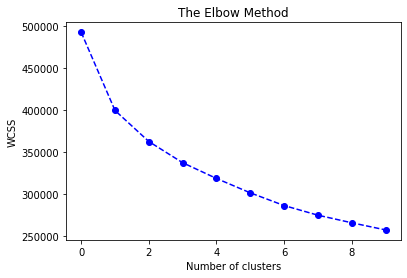

In [66]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
customer_df_ss = ss.fit_transform(final_customer_df)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10,random_state = 42)
    kmeans.fit(customer_df_ss)
    wcss.append(kmeans.inertia_)
plt.plot( wcss, linestyle='--', marker='o', color='b')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [68]:
# Fitting K-Means to the dataset
km_1 = KMeans(n_clusters = 3)
km_1n=km_1.fit_predict(customer_df_ss)
# assign the cluster
cluster_assigned = pd.DataFrame(ss.inverse_transform(customer_df_ss), columns = final_customer_df.columns)
cluster_assigned['cluster_label'] = km_1.labels_ 
cluster_center1 = pd.DataFrame(km_1.cluster_centers_, columns = final_customer_df.columns)


In [69]:
cluster_center1

,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,...,bogo_completion_rate,discount_completion_rate,informational_view_rate,age,gender,income,membership_years,F,M,O
0,0.444120,0.302590,-0.531123,0.348665,0.697448,0.470362,0.388847,-0.474625,0.411320,0.710607,...,0.704153,0.651778,-0.405682,0.320753,0.0,0.397093,0.377051,0.225668,0.008605,0.022770
1,-0.509867,-0.281337,0.677512,-0.275759,-0.738656,-0.483327,-0.215458,0.716055,-0.142056,-0.580256,...,0.199384,0.317657,0.624077,0.320305,0.0,0.359593,0.340220,0.227475,-0.005223,0.026072
2,0.013107,-0.048465,-0.074560,-0.097919,-0.033330,-0.035361,-0.189220,-0.162750,-0.274763,-0.183718,...,-0.854971,-0.907044,-0.149567,-0.588871,0.0,-0.696918,-0.660680,-0.416148,-0.003792,-0.044701


In [70]:
final_customer_df.fillna(0).head()

,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,...,bogo_completion_rate,discount_completion_rate,informational_view_rate,age,gender,income,membership_years,F,M,O
0,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,2.0,...,1.0,1.0,1.0,33.0,0,72000.0,3.0,0,1,0
1,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0
2,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,...,1.0,1.0,1.0,40.0,0,57000.0,2.0,0,0,1
3,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,2.0,...,0.5,1.0,1.0,59.0,0,90000.0,4.0,1,0,0
4,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,3.0,...,1.0,1.0,1.0,24.0,0,60000.0,3.0,1,0,0


In [71]:
km_2 = KMeans(n_clusters = 3)
final_customer_df['cluster']=km_2.fit_predict(customer_df_ss)

In [72]:
final_customer_df.head()

,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,...,discount_completion_rate,informational_view_rate,age,gender,income,membership_years,F,M,O,cluster
0,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,2.0,...,1.0,1.0,33.0,0,72000.0,3.0,0,1,0,2
1,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0,0.0,0.0,0,0,0,1
2,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,...,1.0,1.0,40.0,0,57000.0,2.0,0,0,1,2
3,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,2.0,...,1.0,1.0,59.0,0,90000.0,4.0,1,0,0,2
4,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,3.0,...,1.0,1.0,24.0,0,60000.0,3.0,1,0,0,2


In [102]:
final_customer_df.cluster.head()

0    2
1    1
2    2
3    2
4    2
Name: cluster, dtype: int32

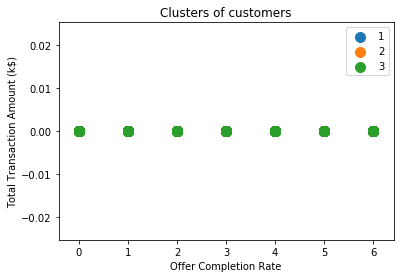

In [186]:
# Visualising the clusters
#plt.scatter(cluster_assigned['offer_completion_rate'], cluster_assigned['total_transaction_amount'])
plt.scatter(cluster_assigned['total_offer_completed'], cluster_assigned['gender'], s = 100, label = '1')
plt.scatter(cluster_assigned['total_offer_completed'], cluster_assigned['gender'], s = 100, label = '2')
plt.scatter(cluster_assigned['total_offer_completed'], cluster_assigned['gender'], s = 100, label = '3')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Offer Completion Rate')
plt.ylabel('Total Transaction Amount (k$)')
plt.legend()
plt.show()

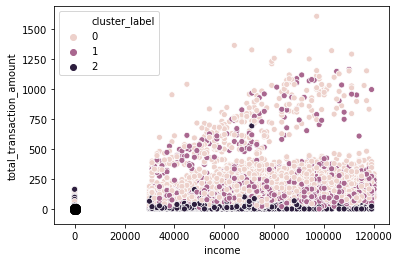

In [187]:
sns.scatterplot(cluster_assigned['income'], cluster_assigned['total_transaction_amount'], 
                hue= cluster_assigned['cluster_label'])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=100, alpha=1);

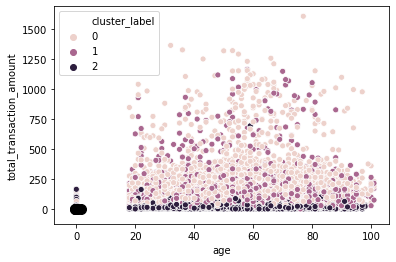

In [197]:

sns.scatterplot(cluster_assigned['age'], cluster_assigned['total_transaction_amount'], 
                hue= cluster_assigned['cluster_label'])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=100, alpha=1);

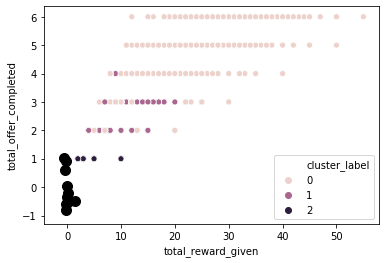

In [203]:
sns.scatterplot(cluster_assigned['total_reward_given'], cluster_assigned['total_offer_completed'], c='red',hue= cluster_assigned['cluster_label'])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=100, alpha=1);

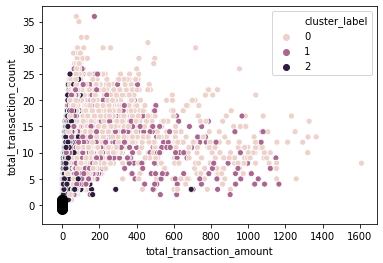

In [206]:
sns.scatterplot(cluster_assigned['total_transaction_amount'], cluster_assigned['total_transaction_count'], c='red',hue= cluster_assigned['cluster_label'])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=100, alpha=1);

In [99]:
final_customer_df.head()

,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,...,discount_completion_rate,informational_view_rate,age,gender,income,membership_years,F,M,O,cluster
0,1.0,2.0,2.0,5.0,3.0,1.0,1.0,2.0,4.0,2.0,...,1.0,1.0,33.0,0,72000.0,3.0,0,1,0,2
1,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0,0.0,0.0,0,0,0,1
2,1.0,2.0,2.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,...,1.0,1.0,40.0,0,57000.0,2.0,0,0,1,2
3,2.0,2.0,1.0,5.0,4.0,1.0,1.0,1.0,3.0,2.0,...,1.0,1.0,59.0,0,90000.0,4.0,1,0,0,2
4,2.0,1.0,1.0,4.0,3.0,2.0,1.0,1.0,4.0,3.0,...,1.0,1.0,24.0,0,60000.0,3.0,1,0,0,2


In [134]:
cluster0=final_customer_df[final_customer_df['cluster']==0].copy()
cluster1=final_customer_df[final_customer_df['cluster']==1].copy()
cluster2=final_customer_df[final_customer_df['cluster']==2].copy()

In [ ]:
    Cluster 1: Medium income, low annual spend
    Cluster 2: Low income, low annual spend
    Cluster 3: High income, high annual spend
    Cluster 4: Low income, high annual spend
    Cluster 5: Medium income, low annual spend
    Cluster 6: Very high income, high annual spend
        
        A typical strategy would focus certain promotional efforts for the high value customers of Cluster 6 & Cluster 3.
    Cluster 4 is a unique customer segment, where in spite of their relatively lower annual income, these customers tend to spend more on the site, indicating their loyalty. There could be some discounted pricing based promotional campaigns for this group so as to retain them.
    For Cluster 2 where both the income and annual spend are low, further analysis could be needed to find the reasons for the lower spend and price-sensitive strategies could be introduced to increase the spend from this segment.
    Customers in clusters 1 and 5 are not spending enough on the site in spite of a good annual income — further analysis of these segments could lead to insights on the satisfaction / dissatisfaction of these customers or lesser visibility of the e-commerce site to these customers. Strategies could be evolved accordingly.

Cluster-0 - regular customer who



In [141]:
cluster0.iloc[:,15:].describe()

,total_transaction_count,total_reward_given,transaction_onlycustomers,offer_view_rate,offer_completion_rate,bogo_completion_rate,discount_completion_rate,informational_view_rate,age,gender,income,membership_years,F,M,O,cluster
count,5799.000000,5799.000000,5799.0,5799.000000,5799.000000,5799.000000,5799.000000,5799.000000,5799.000000,5799.0,5799.000000,5799.000000,5799.000000,5799.000000,5799.000000,5799.0
mean,10.518538,18.629419,0.0,0.813793,0.831824,0.769768,0.810453,0.248635,55.235041,0.0,68832.729781,3.246939,0.468702,0.503535,0.015003,0.0
std,5.348718,8.046247,0.0,0.194540,0.208701,0.337972,0.329756,0.427651,17.735051,0.0,22898.601221,1.185487,0.499062,0.500031,0.121573,0.0
min,1.000000,2.000000,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,6.000000,12.000000,0.0,0.666667,0.750000,0.500000,0.666667,0.000000,45.000000,0.0,53000.000000,2.000000,0.000000,0.000000,0.000000,0.0
50%,10.000000,18.000000,0.0,0.800000,1.000000,1.000000,1.000000,0.000000,57.000000,0.0,69000.000000,3.000000,0.000000,1.000000,0.000000,0.0
75%,14.000000,24.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.500000,67.000000,0.0,85000.000000,4.000000,1.000000,1.000000,0.000000,0.0
max,36.000000,55.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,101.000000,0.0,120000.000000,7.000000,1.000000,1.000000,1.000000,0.0


In [140]:
cluster1.iloc[:,15:].describe()

,total_transaction_count,total_reward_given,transaction_onlycustomers,offer_view_rate,offer_completion_rate,bogo_completion_rate,discount_completion_rate,informational_view_rate,age,gender,income,membership_years,F,M,O,cluster
count,5993.000000,5993.000000,5993.000000,5993.000000,5993.00000,5993.000000,5993.000000,5993.000000,5993.000000,5993.0,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.0
mean,5.778909,1.385283,0.684131,0.697052,0.09691,0.065693,0.101869,0.371169,33.086100,0.0,36313.866177,1.682797,0.161021,0.496913,0.007509,1.0
std,4.100947,2.486190,0.464900,0.257648,0.15589,0.186782,0.231294,0.459815,27.717274,0.0,29317.733125,1.460654,0.367581,0.500032,0.086334,0.0
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,3.000000,0.000000,0.000000,0.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,5.000000,0.000000,1.000000,0.750000,0.00000,0.000000,0.000000,0.000000,35.000000,0.0,41000.000000,2.000000,0.000000,0.000000,0.000000,1.0
75%,8.000000,2.000000,1.000000,1.000000,0.20000,0.000000,0.000000,1.000000,56.000000,0.0,58000.000000,2.000000,0.000000,1.000000,0.000000,1.0
max,27.000000,20.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,98.000000,0.0,119000.000000,7.000000,1.000000,1.000000,1.000000,1.0


In [137]:
#https://towardsdatascience.com/clustering-algorithms-for-customer-segmentation-af637c6830ac
cluster2.describe()

,offer_recieved_bogo,offer_recieved_discount,offer_recieved_informational,total_offer_recieved,total_off_recev_bo_dis,offer_viewed_bogo,offer_viewed_discount,offer_viewed_informational,total_offer_viewed,total_off_viewed_bo+dis,...,discount_completion_rate,informational_view_rate,age,gender,income,membership_years,F,M,O,cluster
count,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,...,5208.000000,5208.000000,5208.000000,5208.0,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,5208.0
mean,1.223502,1.478879,1.488287,4.190668,2.702381,0.986559,1.040323,1.184716,3.211598,2.026882,...,0.659517,0.736802,55.259409,0.0,67749.423963,3.193164,0.469662,0.496544,0.015361,2.0
std,0.872278,0.980282,0.860691,1.104634,0.869063,0.807476,0.862947,0.814020,1.244370,0.897924,...,0.421206,0.390414,18.379325,0.0,23437.882952,1.277186,0.499127,0.500036,0.122996,0.0
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,1.000000,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,1.000000,2.000000,1.000000,...,0.333333,0.500000,45.000000,0.0,52000.000000,2.000000,0.000000,0.000000,0.000000,2.0
50%,1.000000,1.000000,1.000000,4.000000,3.000000,1.000000,1.000000,1.000000,3.000000,2.000000,...,1.000000,1.000000,57.000000,0.0,67000.000000,3.000000,0.000000,0.000000,0.000000,2.0
75%,2.000000,2.000000,2.000000,5.000000,3.000000,2.000000,2.000000,2.000000,4.000000,3.000000,...,1.000000,1.000000,67.000000,0.0,84000.000000,4.000000,1.000000,1.000000,0.000000,2.0
max,4.000000,5.000000,5.000000,6.000000,5.000000,4.000000,4.000000,5.000000,6.000000,4.000000,...,1.000000,1.000000,101.000000,0.0,120000.000000,7.000000,1.000000,1.000000,1.000000,2.0


In [ ]:
# lets answer questions to understand transcript dataframe

print('How many transaction are related to offer sent to the customer')
print(len(transcript_df[(transcript_df['offer_id'].notnull()) & (transcript_df['reward_given'].notnull())]))

print('How many customers did not respond to the sent offer')
print(transcript_df[(transcript_df['offer_id'].notnull()) & (transcript_df['reward_given'].isnull()).count()])

# This may contain some informational offer related transaction
print('How many customers transactions are related did not respond to the sent offer')
print(len(transcript_df[(transcript_df['amount'].notnull())]))





In [ ]:
# check offer type and events count
df_temp = transcript_df.merge(portfolio_df,how='left',on='offer_id')

df_temp.groupby(['event','offer_type'])['offer_type'].count().plot.bar()

df_temp.groupby(['event','offer_type'])['offer_type'].count()

In [ ]:
# informational offer related transaction 


In [ ]:
# Let's check how many rewards are given overall 
df_temp.groupby('offer_type')['reward_given'].count()

In [ ]:
plt.scatter(final_customer_df[y_means==0,0],X[y_means==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(X[y_means==1,0],X[y_means==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(X[y_means==2,0],X[y_means==2,1],s=50, c='green',label='Cluster3')
plt.scatter(X[y_means==3,0],X[y_means==3,1],s=50, c='cyan',label='Cluster4')

ValueError: 'c' argument has 17000 elements, which is not acceptable for use with 'x' with size 0, 'y' with size 0.

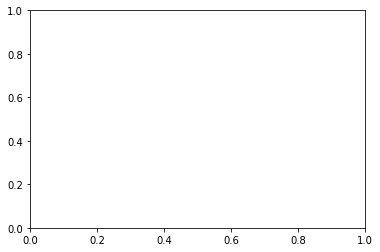

In [208]:
sns.scatterplot(cluster_assigned['age'], cluster_assigned['total_offer_completed'], c=km_1n, s=50, cmap='viridis',label= cluster_assigned['cluster_label'])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
plt.scatter(cluster_assigned['income'], cluster_assigned['total_transaction_amount'], s = 100, c = 'red', label = 'cluster_label')

In [ ]:
sns.scatterplot(cluster_assigned['total_transaction_amount'], cluster_assigned['total_reward_given'], hue= cluster_assigned['cluster_label'])
plt.legend(bbox_to_anchor=(1.00, 0.5), loc=3);

In [ ]:
sns.scatterplot(cluster_assigned['gender'], cluster_assigned['total_offer_completed'], hue= cluster_assigned['cluster_label'])
plt.legend(bbox_to_anchor=(1.00, 0.5), loc=3);

In [ ]:
customer_new = pd.concat([df_temp,pd.get_dummies(df_temp.event)], axis = 1).copy()

In [ ]:
customer_new.columns

In [ ]:
demographic_df.fillna(0).head()

In [ ]:
df_customer=pd.merge(df_temp,profile_df,on='customer_id',how='left')

In [ ]:
df_customer.fillna(0,inplace=True)

df_demographic =demographic_df.copy()


In [ ]:
df_demographic.set_index('customer_id', inplace = True, 
                            append = False, drop = True)


In [ ]:
def get_person_record (customer_id):
    '''
    input: a person id
    output: a dataframe of all the records of the person
    '''
    trans_recs = df_customer.loc[df_customer['customer_id'] == customer_id,:].reset_index(drop=True)
    return trans_recs

In [ ]:
from collections import defaultdict
person_off_trans = defaultdict(lambda: defaultdict(float))
person_effective_offer = defaultdict(list)
bogo_discount_offer_ids = portfolio_df[portfolio_df['offer_type'].isin(['bogo', 'discount'])]['offer_id'].values

In [ ]:
import progressbar
cnter = 0
pbar = progressbar.ProgressBar(maxval=demographic_df.shape[0], widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for uid in df_demographic.index:
    
    cnter+=1 
    pbar.update(cnter)
    
    trans_recs = get_person_record(uid)
    off_rec_ind = trans_recs[trans_recs['event'] == 'offer received'].index.values
    transactions = trans_recs[trans_recs.event == 'transaction']
#     profile_trans.loc[person, 'trans_count'] = transactions.shape[0]
#     profile_trans.loc[person, 'trans_total'] = transactions['trans_amount'].sum()

    trans_off_ind = []
    
    for r_i in off_rec_ind:
        offer_id = trans_recs.loc[r_i, 'offer_id']
        offer_valid_for = int(portfolio_df[portfolio_df['offer_id'] == offer_id]['duration']) * 24
        offer_start = trans_recs.loc[r_i, 'time']
        offer_end = offer_start + offer_valid_for
        
        viewed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer viewed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
        
        if viewed.shape[0] >0 :
            person_off_trans[uid]['offer_view'] += 1
            if offer_id in bogo_discount_offer_ids:
                completed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer completed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
                if completed.shape[0] > 0 :
                    view_ind = viewed.index[0]
                    comp_ind = completed.index[0]
                    conv_offer_type = completed['offer_type'].values[0]
                    offer_difficulty = completed['difficulty'].values[0]
                    
                    if view_ind < comp_ind:
                        person_off_trans[uid]['offer_comp'] += 1
                        person_off_trans[uid][conv_offer_type] += 1
                        bogo_disc_trans = transactions.loc[view_ind:comp_ind].amount.sum()
                        person_off_trans[uid]['offer_trans_amt'] += bogo_disc_trans
                        person_off_trans[uid]['offer_difficulty'] += offer_difficulty 
                        
                        if offer_id not in person_effective_offer[uid]:
                            person_effective_offer[uid].append(offer_id)
                    
            else:
                view_time = viewed.iloc[0]['time']
                person_off_trans[uid]['offer_view'] += 1
                info_trans = trans_recs[(trans_recs['event'] == 'transaction') &
                                       (trans_recs['time'] >= view_time) &
                                       (trans_recs['time'] <= offer_end)]
                if info_trans.shape[0] > 0:
                    person_off_trans[uid]['offer_comp'] += 1                    
                    info_tran_amt = info_trans['amount'].sum()
                    person_off_trans[uid]['offer_trans_amt'] += info_tran_amt
                    person_off_trans[uid]['informational'] +=1
                    if offer_id not in person_effective_offer[uid]:
                        person_effective_offer[uid].append(offer_id)

In [ ]:
person_off_trans_df = pd.DataFrame.from_dict(person_off_trans, orient = 'index')

In [ ]:
person_off_trans_df.fillna(0).head()

In [ ]:
def kmeans_score(data, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [ ]:
#Running the kmeans_score function for a number of different cluster patterns
scores = []
for i in range(1, 20):
    score = kmeans_score(final_customer_df, i)
    scores.append(score)

In [ ]:

#Plotting results from the previous cell; noting that we begin seeing after about 6 clusters
centers = range(1, 20)
plt.plot(centers, scores, linestyle = '--', marker = 'o');
plt.style.use('seaborn');
plt.title('KMeans SSE Scores as K Increases');
plt.ylabel('SSE');
plt.xlabel('Number of Clusters (K)');

In [ ]:
https://www.kaggle.com/roshansharma/mall-customers-clustering-analysis
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
ymeans = kmeans.fit_predict(x)

plt.rcParams['figure.figsize'] = (10, 10)
plt.title('Cluster of Ages', fontsize = 30)

plt.scatter(x[ymeans == 0, 0], x[ymeans == 0, 1], s = 100, c = 'pink', label = 'Usual Customers' )
plt.scatter(x[ymeans == 1, 0], x[ymeans == 1, 1], s = 100, c = 'orange', label = 'Priority Customers')
plt.scatter(x[ymeans == 2, 0], x[ymeans == 2, 1], s = 100, c = 'lightgreen', label = 'Target Customers(Young)')
plt.scatter(x[ymeans == 3, 0], x[ymeans == 3, 1], s = 100, c = 'red', label = 'Target Customers(Old)')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 50, c = 'black')

plt.style.use('fivethirtyeight')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid()
plt.show()

# Reference
https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby/45925961
https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes
https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
https://stackoverflow.com/questions/50522146/pandas-column-dict-split-to-new-column-and-rows
https://stackoverflow.com/questions/56421683/how-to-apply-a-function-for-each-row-of-a-dataframe-which-checks-keys-of-embedd
https://stackoverflow.com/questions/41455967/convert-datetime-string-to-new-columns-of-day-month-year-in-pandas-data-frame/41456152

https://stackoverflow.com/questions/43133605/convert-integer-yyyymmdd-to-date-format-mm-dd-yyyy-in-python
https://stackoverflow.com/questions/17134716/convert-dataframe-column-type-from-string-to-datetime-dd-mm-yyyy-format

https://stackoverflow.com/questions/49742938/checking-isdigit-on-python
 https://towardsdatascience.com/flattening-json-objects-in-python-f5343c794b10
 
 https://medium.com/@vinitasilaparasetty/guide-to-defining-problem-statements-baf52219ea5b
 
 https://medium.com/@george.drakos62/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca

# we need to seperate effective offer dataset

1 - effective offer 
0 - not an effective
informational offer
